# Wavenet

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# words = open("names.txt", "r").read().splitlines()
words = open("1.Abstract.txt").read().splitlines()
words[:10]

['March 2024',
 '',
 'I met the Reddits before we even started Y Combinator. In fact they were one of the reasons we started it.',
 '',
 "YC grew out of a talk I gave to the Harvard Computer Society (the undergrad computer club) about how to start a startup. Everyone else in the audience was probably local, but Steve and Alexis came up on the train from the University of Virginia, where they were seniors. Since they'd come so far I agreed to meet them for coffee. They told me about the startup idea we'd later fund them to drop: a way to order fast food on your cellphone.",
 '',
 "This was before smartphones. They'd have had to make deals with cell carriers and fast food chains just to get it launched. So it was not going to happen. It still doesn't exist, 19 years later. But I was impressed with their brains and their energy. In fact I was so impressed with them and some of the other people I met at that talk that I decided to start something to fund them. A few days later I told Steve

In [6]:
len(words)

8467

In [8]:
### mappings 
chars = sorted(list(set("".join(words))))
if "." in chars:
    stoi = {s:i for i,s in enumerate(chars)}
else:
    stoi = {s:i+1 for i,s in enumerate(chars)}
    stoi["."] = 0
    
itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)

In [9]:
vocab_size

99

In [10]:
## build the dataset
block_size = 8

def build_data(words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w + ".":
            ix = stoi[ch]
            Y.append(ix)
            X.append(context)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr   = build_data(words[:n1])     ## train 80%
Xval, Yval = build_data(words[n1:n2])   ## val   10%
Xte, Yte   = build_data(words[n2:])     ## test  10%


torch.Size([1075300, 8]) torch.Size([1075300])
torch.Size([143184, 8]) torch.Size([143184])
torch.Size([135902, 8]) torch.Size([135902])


In [11]:
g = torch.Generator().manual_seed(2100)

############################################## LINEAR LAYER ##############################################
class Linear:

    def __init__(self, fan_in, fan_out, generator = g, bias = True):
        self.weights = torch.randn((fan_in, fan_out),  generator = g) * (1/fan_in**0.5)
        self.bias  = torch.randn(fan_out,  generator = g) if bias else None
        self.training = True
        
    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])
    
############################################## BATCH NORM LAYER ##############################################

class BatchNormld:
    
    def __init__(self, dim, eps= 1e-5, momentum = 0.01,training = True):
        
        self.eps = eps
        self.momentum = momentum
        
        self.training = True
        ## trainable parameters
        self.gamma = torch.ones((dim,))
        self.beta  = torch.zeros((dim,))
        
        ## running estimates of mean and var
        
        self.mean_running = torch.zeros((dim,))
        self.var_running  = torch.ones((dim,))
        
    def __call__(self, x):
        
        if self.training:
            
            xmean = x.mean(0, keepdim = True)
            xvar  = x.var(0, keepdim = True)
        else:
            
            xmean = self.mean_running
            xvar  = self.var_running
            
        with torch.no_grad():
            if self.training:
                self.mean_running = (1-self.momentum)*self.mean_running + self.momentum*xmean
                self.var_running  = (1-self.momentum)*self.var_running  + self.momentum*xvar
        
        self.out = (x - xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gamma * self.out + self.beta
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
############################################## TANH LAYER ##############################################
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
############################################# Embedding layer ##########################################################

class Embedding:
    def __init__(self, vocab_size, n_emb, generator = g):
        self.C = torch.randn((vocab_size, n_emb),  generator = g) 
        self.training = True
        
    def __call__(self, x):
        self.out = self.C[x]
        return self.out
    
    def parameters(self):
        return [self.C] 
############################################# Flatten Layer ##########################################################

class Flatten:
    
    def __call__(self, x): 
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return [] 

############################################# Container ##########################################################
 
class Sequential:
    
    def __init__(self, layers, generator = g):
        self.layers = layers
        self.training = True
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        parameters = [p for layer in layers for p in layer.parameters()]
        return parameters 
    

In [13]:
### lets create a Flatten consecutive module
class FlattenConsecutive:
    
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B,T,C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            ## if there is a spurious dimention( dim == 1)
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

### There is a Bug in BatchNorm
############################################## BATCH NORM LAYER ##############################################

class BatchNormld:
    
    def __init__(self, dim, eps= 1e-5, momentum = 0.01,training = True):
        
        self.eps = eps
        self.momentum = momentum
        
        self.training = True
        ## trainable parameters
        self.gamma = torch.ones((dim,))
        self.beta  = torch.zeros((dim,))
        
        ## running estimates of mean and var
        
        self.mean_running = torch.zeros((dim,))
        self.var_running  = torch.ones((dim,))
        
    def __call__(self, x):
        
        if self.training:
            if x.ndim ==2:
                dim = 0
            elif x.ndim ==3:
                dim = (0,1)
                
            xmean = x.mean(dim, keepdim = True)
            xvar  = x.var(dim, keepdim = True)
        else:
            
            xmean = self.mean_running
            xvar  = self.var_running
            
        with torch.no_grad():
            if self.training:
                self.mean_running = (1-self.momentum)*self.mean_running + self.momentum*xmean
                self.var_running  = (1-self.momentum)*self.var_running  + self.momentum*xvar
        
        self.out = (x - xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gamma * self.out + self.beta
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [14]:
g = torch.Generator().manual_seed(2100)
nemb    = 20
nhidden = 200

# the model

layers = [Embedding(vocab_size, nemb),FlattenConsecutive(2),
          Linear(2*nemb, nhidden, generator = g), BatchNormld(nhidden), Tanh(), FlattenConsecutive(2),
          Linear(2*nhidden, nhidden, generator = g), BatchNormld(nhidden), Tanh(),FlattenConsecutive(2),
          Linear(2*nhidden, vocab_size, generator = g)]

model = Sequential(layers)


with torch.no_grad():
 # make model less confident at initialization
    model.layers[-1].weights *= 0.1
 # apply gain for well behaved inputs to Tanh
    for layer in model.layers[1:-1]: ## not applied to the Emb and last layers
        if  isinstance(layer, Linear):
            layer.weights *= 5/3      #### Kaiming Normalization


for p in model.parameters():
    p.requires_grad = True



In [15]:
### Stochastic Gradient Descent

epochs     = 200000
batch_size = 200
history    = []
ud         = [] ## update ratio (lr x grad/data)
for epoch in range(epochs):
    
    ## Construct Mini Batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    xb, yb = Xtr[ix], Ytr[ix]
    
    ## forward pass
    logits = model(xb)
    loss = F.cross_entropy(logits, yb)
    
    ## Backward pass
    for layer in model.layers:
        layer.out.retain_grad() ## would take out the retain graph
        
    for p in model.parameters():
        p.grad = None
    
    loss.backward()
    
    ## update
    
    lr = 0.01 if epoch < 100000 else 0.001
    
    for p in model.parameters():
        p.data -= lr*p.grad
    
    ## track stats
    if epoch%10000 == 0:
        print(f'{epoch:7d}/{epochs:7d} : {loss.item():.4f}')
           
    history.append(loss.item())
    
#     break

      0/ 200000 : 4.8524
  10000/ 200000 : 1.9311
  20000/ 200000 : 1.8268
  30000/ 200000 : 1.8019
  40000/ 200000 : 1.8855
  50000/ 200000 : 1.4739
  60000/ 200000 : 1.5340
  70000/ 200000 : 1.5611
  80000/ 200000 : 1.4131
  90000/ 200000 : 1.4183
 100000/ 200000 : 1.6851
 110000/ 200000 : 1.5175
 120000/ 200000 : 1.3281
 130000/ 200000 : 1.4785
 140000/ 200000 : 1.5206
 150000/ 200000 : 1.5150
 160000/ 200000 : 1.3137
 170000/ 200000 : 1.4080
 180000/ 200000 : 1.4506
 190000/ 200000 : 1.4794


In [16]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (200, 8, 20)
FlattenConsecutive : (200, 4, 40)
Linear : (200, 4, 200)
BatchNormld : (200, 4, 200)
Tanh : (200, 4, 200)
FlattenConsecutive : (200, 2, 400)
Linear : (200, 2, 200)
BatchNormld : (200, 2, 200)
Tanh : (200, 2, 200)
FlattenConsecutive : (200, 400)
Linear : (200, 99)


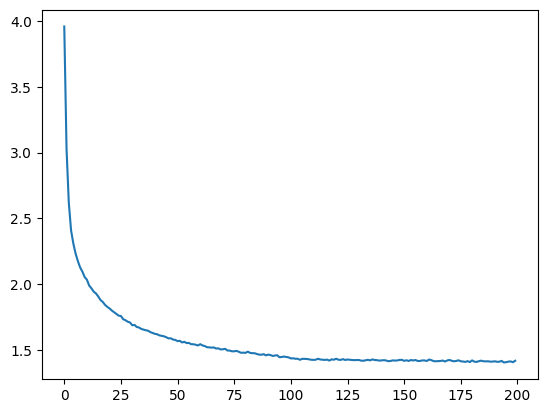

In [17]:
plt.plot(torch.tensor(history).view(-1, 1000).mean(1));

In [18]:
### Put model in train == False model
for layer in model.layers:
    layer.training = False

In [ ]:
## Evaluate the model
@torch.no_grad() ## disables grad tracking
def split_loss(split):
    x,y = {'train': (Xtr, Ytr),
           'val':   (Xval, Yval),
           'test':  (Xte, Yte)}[split]
    
    logits = model(x)
    loss   = F.cross_entropy(logits, y)
    
    print(split, loss.item())
    
split_loss('train')
split_loss('val')
# split_loss('test') 

In [ ]:
## sampling from the models - generation step

g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    
    out     = []
    context = [0]*block_size
    
    while True:
        
        logits   = model(torch.tensor(context).view(1,-1))
        probs    = F.softmax(logits, dim = 1)
        ix       = torch.multinomial(probs, num_samples = 1, generator =g).item()
        context  = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 14:
            break
        
    print("".join(out))